## Initial Data Understanding and Preprocessing


In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score
import scipy.stats as stats

# Load the data
df = pd.read_excel("HBA_SALES_DATA_v1.xlsx")

# Check the shape of the data
print(f"Dataset shape: {df.shape}")

# Display basic information
print(df.info())

# Check summary statistics
print(df.describe())



Dataset shape: (112, 182)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 112 entries, 0 to 111
Columns: 182 entries, style to max_qty_sold_at_store
dtypes: bool(1), float64(7), int64(135), object(39)
memory usage: 158.6+ KB
None
       bag_height  bag_width  gusset_width  number_of_compartments  \
count   64.000000  69.000000     66.000000              112.000000   
mean    17.829844  23.131304      8.525303                1.017857   
std      6.625618   7.274125      3.364782                0.133027   
min      7.700000  10.300000      0.300000                1.000000   
25%     12.500000  18.000000      6.450000                1.000000   
50%     17.250000  22.800000      8.350000                1.000000   
75%     21.700000  27.000000     10.700000                1.000000   
max     35.500000  45.000000     16.500000                2.000000   

       logo_visibility  number_of_interior_pockets  \
count       112.000000                  112.000000   
mean          0.008929       

### Data Cleaning and Preparation


In [4]:
# Check for missing values
missing_values = df.isnull().sum()
print("Columns with missing values:")
print(missing_values[missing_values > 0])

# Handle missing values for numeric columns
numeric_cols = df.select_dtypes(include=['float64', 'int64']).columns
for col in numeric_cols:
    if df[col].isnull().sum() > 0:
        # Replace with median for numeric columns
        df[col] = df[col].fillna(df[col].median())

# Focus on key sales metrics
sales_cols = ['net_sales_qty_sum', 'net_sales_amt_lcl_sum', 'max_qty_sold_at_store']

# Remove rows with negative sales values (likely returns or adjustments)
df = df[df['net_sales_qty_sum'] >= 0]

# Create a new feature for price per item
df['price_per_item'] = df['net_sales_amt_lcl_sum'] / df['net_sales_qty_sum'].replace(0, np.nan)

Columns with missing values:
bag_height                48
bag_width                 43
gusset_width              46
zipper_type               52
interior_organization     46
stitch_visibility         41
logo_placement            53
logo_style                58
logo_type                 50
symmetry                  25
ease_of_access            41
subcollection              1
material                  14
material_type_y           28
collaboration            112
style_group                1
dtype: int64


d:\Users\gkharad\Documents\coach-hb-fe-etl\.venv\Lib\site-packages\numpy\lib\_nanfunctions_impl.py:1215: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis, out=out, keepdims=keepdims)


## Feature Analysis and Sales Correlation


In [6]:
sales_cols

['net_sales_qty_sum', 'net_sales_amt_lcl_sum', 'max_qty_sold_at_store']

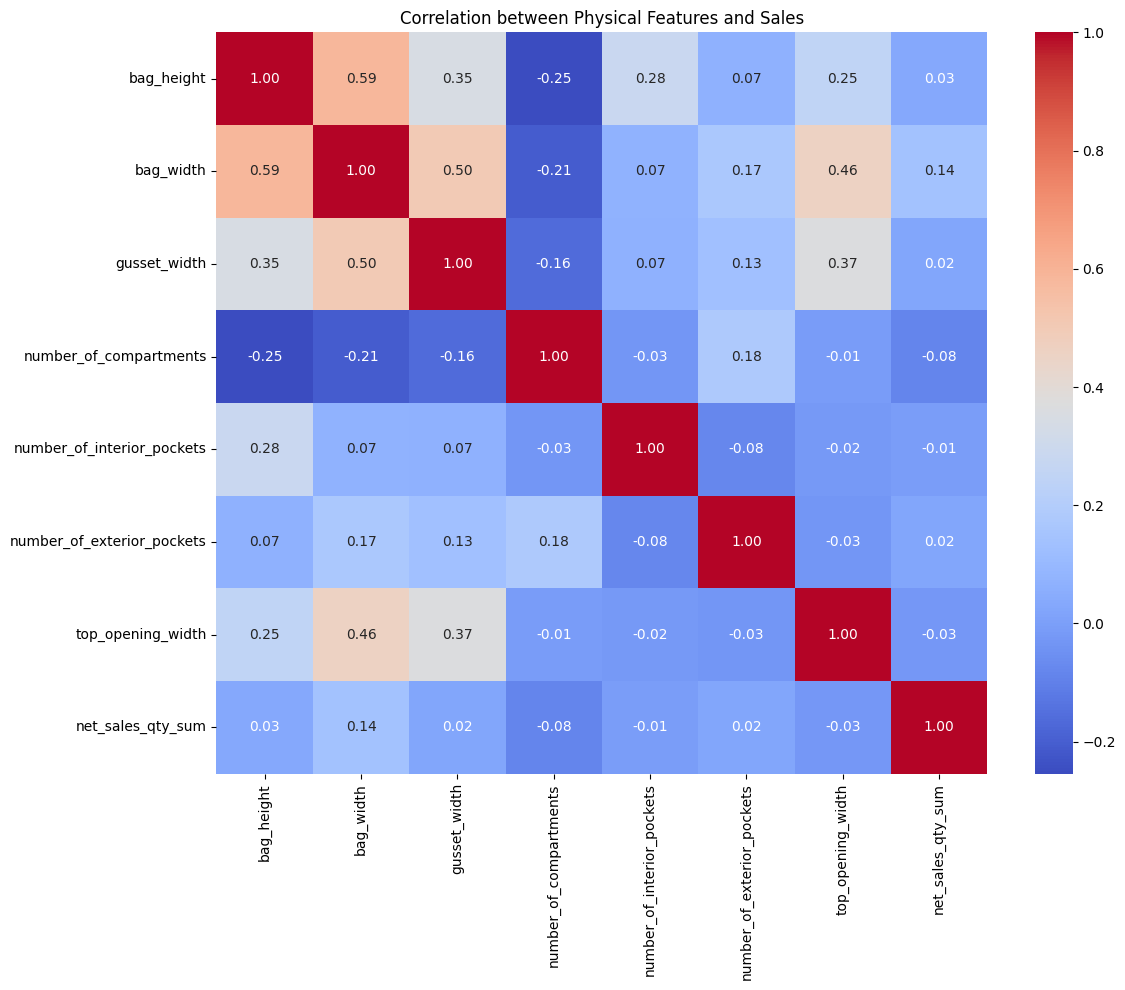

In [8]:
# Select key physical features
physical_features = ['bag_height', 'bag_width', 'gusset_width', 
                    'number_of_compartments', 'number_of_interior_pockets', 
                    'number_of_exterior_pockets', 'top_opening_width']

# Clean up physical features (convert to numeric if needed)
for col in physical_features:
    if df[col].dtype == 'object':
        df[col] = pd.to_numeric(df[col], errors='coerce')
    
# Calculate correlation with sales metrics
correlation_matrix = df[physical_features + ["net_sales_qty_sum"]].corr()

# Plot correlation heatmap
plt.figure(figsize=(12, 10))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt='.2f')
plt.title('Correlation between Physical Features and Sales')
plt.tight_layout()
plt.show()

### Categorical Feature Analysis



Top 5 leather_texture categories by sales:


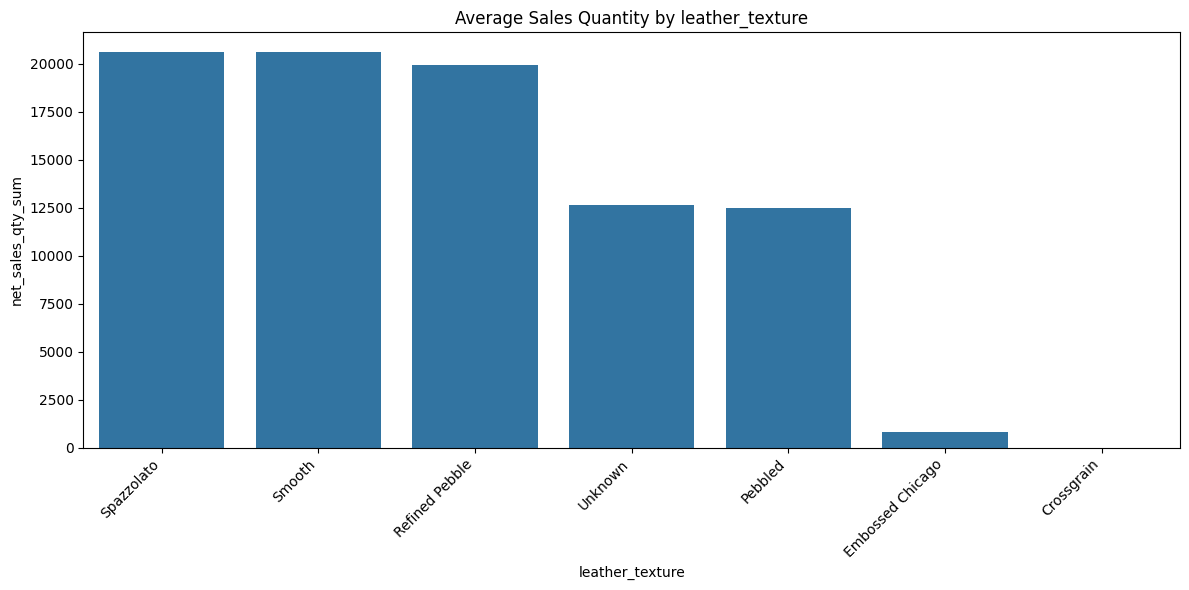

  leather_texture  net_sales_qty_sum  net_sales_amt_lcl_sum  \
5      Spazzolato       20619.500000           3.585317e+06   
4          Smooth       20599.400000           3.008397e+06   
3  Refined Pebble       19924.000000           2.803194e+06   
6         Unknown       12650.728395           1.614949e+06   
2         Pebbled       12485.000000           1.463426e+06   

   max_qty_sold_at_store  
5             9792.50000  
4             7266.40000  
3             7032.00000  
6             5829.37037  
2             4169.60000  

Top 5 hardware_color categories by sales:


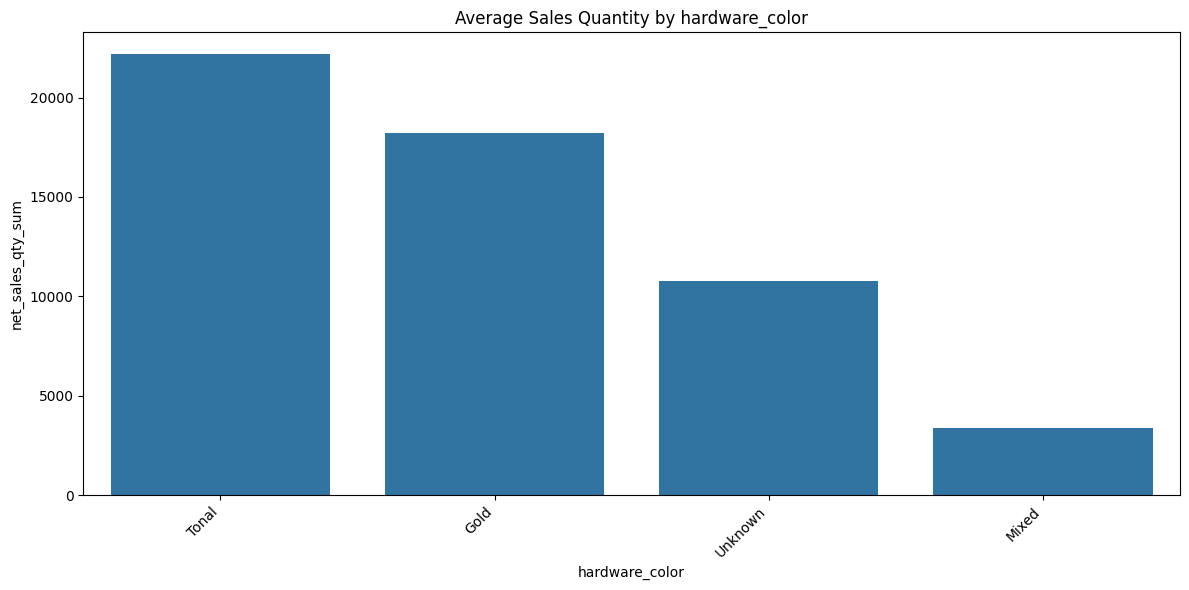

  hardware_color  net_sales_qty_sum  net_sales_amt_lcl_sum  \
2          Tonal       22173.000000           2.066597e+06   
0           Gold       18201.666667           2.529275e+06   
3        Unknown       10767.246377           1.336939e+06   
1          Mixed        3365.000000           3.188380e+05   

   max_qty_sold_at_store  
2            9370.000000  
0            7160.866667  
3            5100.623188  
1             966.000000  

Top 5 closure_type categories by sales:


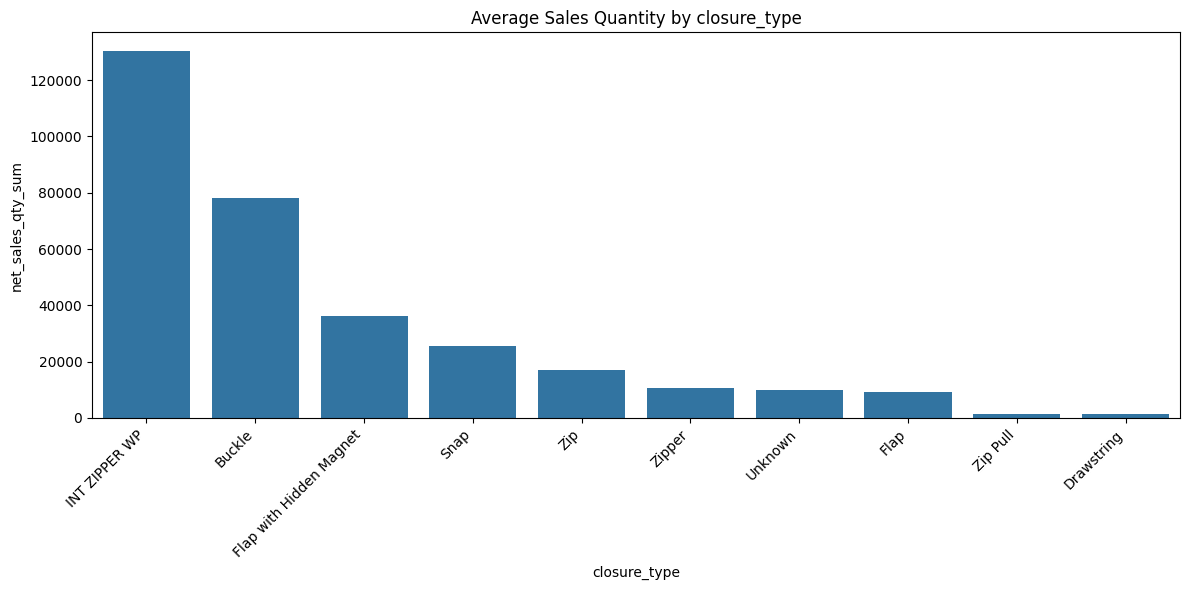

               closure_type  net_sales_qty_sum  net_sales_amt_lcl_sum  \
6             INT ZIPPER WP           130467.0            14632120.64   
0                    Buckle            78207.0            11625866.71   
3   Flap with Hidden Magnet            36254.0             5253843.02   
8                      Snap            25573.0             1378758.69   
11                      Zip            17193.0             1437482.61   

    max_qty_sold_at_store  
6                 94816.0  
0                 31013.0  
3                 13234.0  
8                 13563.0  
11                 5589.0  

Top 5 strap_type categories by sales:


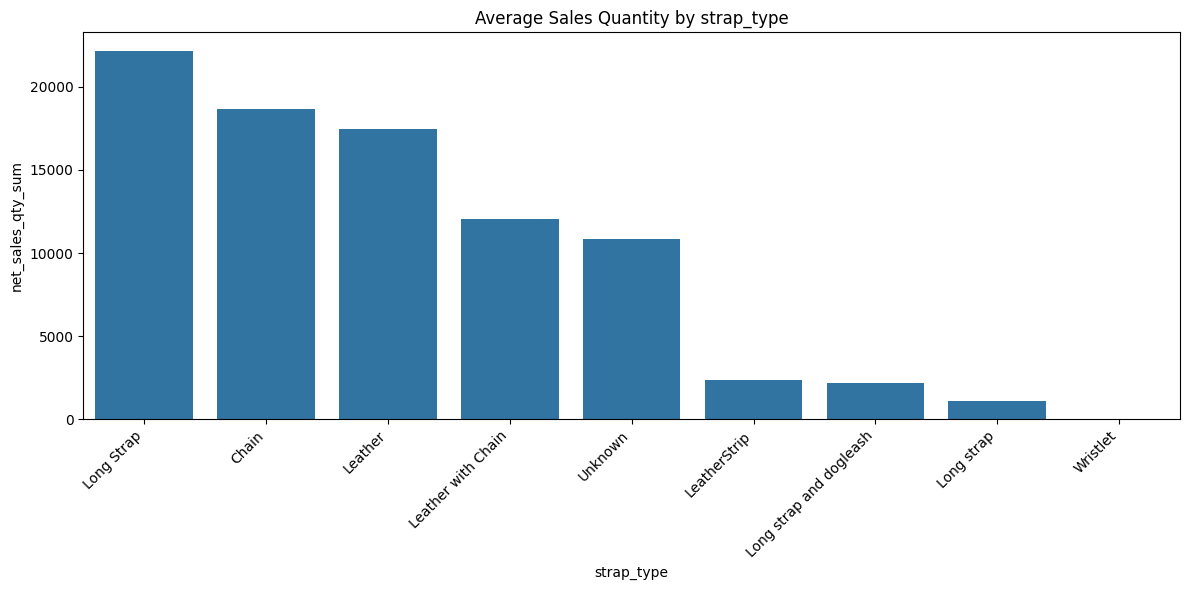

           strap_type  net_sales_qty_sum  net_sales_amt_lcl_sum  \
4          Long Strap       22173.000000           2.066597e+06   
0               Chain       18675.400000           2.925548e+06   
1             Leather       17480.800000           2.525114e+06   
2  Leather with Chain       12038.500000           1.284414e+06   
7             Unknown       10816.142857           1.210964e+06   

   max_qty_sold_at_store  
4            9370.000000  
0            6640.600000  
1            6874.428571  
2            8031.750000  
7            5222.734694  

Top 5 collection_line categories by sales:


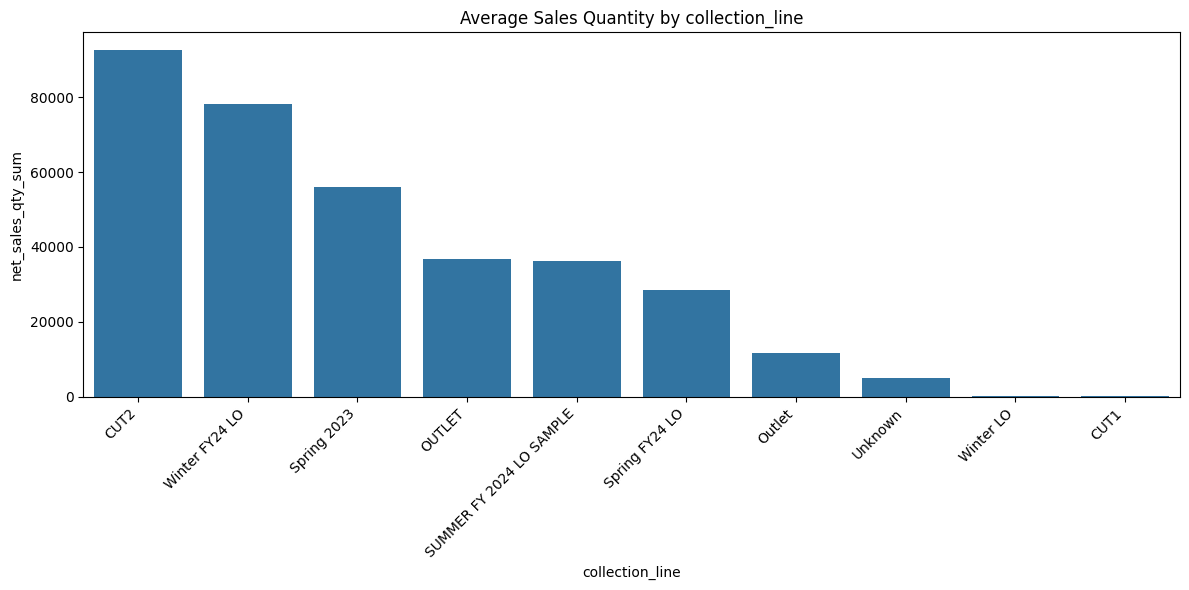

             collection_line  net_sales_qty_sum  net_sales_amt_lcl_sum  \
1                       CUT2            92717.5           1.285831e+07   
15            Winter FY24 LO            78207.0           1.162587e+07   
11               Spring 2023            56049.0           8.351664e+06   
6                     OUTLET            36769.5           1.989572e+06   
9   SUMMER FY 2024 LO SAMPLE            36254.0           5.253843e+06   

    max_qty_sold_at_store  
1                 55298.0  
15                31013.0  
11                14582.0  
6                 11141.5  
9                 13234.0  


In [10]:
# Analyze categorical features
cat_features = ['material_type_x', 'leather_texture', 'hardware_color', 
               'closure_type', 'silhouette_type', 'strap_type', 'collection_line']

df['strap_type'] = df['strap_type'].replace(['Chain with Leather', 'Chain with leather'], 'Leather with Chain')
df['strap_type'] = df['strap_type'].str.lower()
# Function to analyze sales by categorical feature
def analyze_categorical_feature(feature):
    # Group by feature and calculate mean sales
    grouped = df.groupby(feature)[sales_cols].mean().reset_index()
    grouped = grouped.sort_values('net_sales_qty_sum', ascending=False)
    
    # Plot the results
    plt.figure(figsize=(12, 6))
    sns.barplot(x=feature, y='net_sales_qty_sum', data=grouped.head(10))
    plt.title(f'Average Sales Quantity by {feature}')
    plt.xticks(rotation=45, ha='right')
    plt.tight_layout()
    plt.show()
    
    # Return top categories
    return grouped.head(5)

# Analyze each categorical feature
for feature in cat_features:
    if df[feature].nunique() < 20:  # Only analyze if not too many unique values
        print(f"\nTop 5 {feature} categories by sales:")
        print(analyze_categorical_feature(feature))

## Advanced Analysis: Predictive Modeling


In [ ]:
# Prepare data for modeling
# Select relevant features (both numerical and categorical)
model_features = physical_features + [
    'hardware_quality_encoded', 'bottom_structure_encoded',
    'seasonal_relevance_encoded', 'total_carry_options',
    'total_pockets', 'structure_score'
]

# Drop rows with NA in selected features
model_df = df[model_features + ['net_sales_qty_sum']].dropna()

# Split features and target
X = model_df[model_features]
y = model_df['net_sales_qty_sum']

# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Scale features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Train random forest regressor
rf = RandomForestRegressor(n_estimators=100, random_state=42)
rf.fit(X_train_scaled, y_train)

# Evaluate model
y_pred = rf.predict(X_test_scaled)
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print(f"Model MSE: {mse:.2f}")
print(f"Model R²: {r2:.2f}")

# Feature importance
feature_importance = pd.DataFrame({
    'Feature': model_features,
    'Importance': rf.feature_importances_
})
feature_importance = feature_importance.sort_values('Importance', ascending=False)

# Plot feature importance
plt.figure(figsize=(10, 8))
sns.barplot(x='Importance', y='Feature', data=feature_importance)
plt.title('Feature Importance for Predicting Sales')
plt.tight_layout()
plt.show()

## Analysis of Low-Selling Products


In [ ]:
# Define low-selling products (bottom 25%)
sales_threshold = df['net_sales_qty_sum'].quantile(0.25)
low_selling = df[df['net_sales_qty_sum'] <= sales_threshold]

# Compare characteristics of low-selling vs high-selling products
high_selling = df[df['net_sales_qty_sum'] > df['net_sales_qty_sum'].quantile(0.75)]

# Function to compare distributions
def compare_feature_distribution(feature):
    plt.figure(figsize=(10, 6))
    
    # Check if the feature is numeric
    if pd.api.types.is_numeric_dtype(df[feature]):
        # For numeric features, create histograms
        sns.histplot(low_selling[feature].dropna(), kde=True, alpha=0.5, label='Low-selling', color='red')
        sns.histplot(high_selling[feature].dropna(), kde=True, alpha=0.5, label='High-selling', color='green')
        plt.legend()
    else:
        # For categorical features, create a grouped bar chart
        low_counts = low_selling[feature].value_counts().head(5)
        high_counts = high_selling[feature].value_counts().head(5)
        
        # Combine and plot
        counts_df = pd.DataFrame({
            'Low-selling': low_counts,
            'High-selling': high_counts
        }).fillna(0)
        
        counts_df.plot(kind='bar', figsize=(10, 6))
    
    plt.title(f'Distribution of {feature} for Low vs High Selling Products')
    plt.tight_layout()
    plt.show()

# Compare key features
key_features_to_compare = ['bag_height', 'bag_width', 'gusset_width', 
                          'material_type_x', 'silhouette_type', 'closure_type',
                          'price_per_item', 'total_pockets']

for feature in key_features_to_compare:
    if feature in df.columns:
        compare_feature_distribution(feature)

# Statistical comparison of low vs high selling products
print("Statistical comparison of low vs high selling products:")
for feature in physical_features:
    if feature in df.columns:
        # Skip if too many missing values
        if df[feature].isnull().sum() > len(df) * 0.5:
            continue
            
        low_values = low_selling[feature].dropna()
        high_values = high_selling[feature].dropna()
        
        # Skip if not enough data
        if len(low_values) < 5 or len(high_values) < 5:
            continue
            
        # Calculate mean and run statistical test
        low_mean = low_values.mean()
        high_mean = high_values.mean()
        
        try:
            t_stat, p_value = stats.ttest_ind(low_values, high_values, nan_policy='omit')
            significance = "Significant" if p_value < 0.05 else "Not significant"
            print(f"{feature}: Low-selling mean: {low_mean:.2f}, High-selling mean: {high_mean:.2f}, p-value: {p_value:.4f}, {significance}")
        except:
            print(f"Could not run statistical test for {feature}")

## Summary of Key Findings


In [ ]:
# Summarize top selling features
top_silhouettes = df.groupby('silhouette_type')['net_sales_qty_sum'].mean().sort_values(ascending=False).head(5)
top_materials = df.groupby('material_type_x')['net_sales_qty_sum'].mean().sort_values(ascending=False).head(5)
top_closure = df.groupby('closure_type')['net_sales_qty_sum'].mean().sort_values(ascending=False).head(5)

# Optimal dimensions
optimal_height = df[df['net_sales_qty_sum'] > df['net_sales_qty_sum'].median()]['bag_height'].median()
optimal_width = df[df['net_sales_qty_sum'] > df['net_sales_qty_sum'].median()]['bag_width'].median()
optimal_gusset = df[df['net_sales_qty_sum'] > df['net_sales_qty_sum'].median()]['gusset_width'].median()

In [ ]:

print("\n===== SUMMARY OF KEY FINDINGS =====")
print("\nTop Selling Silhouettes:")
print(top_silhouettes)

print("\nTop Selling Materials:")
print(top_materials)

print("\nTop Selling Closure Types:")
print(top_closure)

print(f"\nOptimal Bag Dimensions for High Sales:")
print(f"Height: {optimal_height:.1f} cm")
print(f"Width: {optimal_width:.1f} cm")
print(f"Gusset/Depth: {optimal_gusset:.1f} cm")

# Features of low-selling products
low_selling_features = {
    'silhouette_types': low_selling['silhouette_type'].value_counts().head(3).index.tolist(),
    'materials': low_selling['material_type_x'].value_counts().head(3).index.tolist(),
    'avg_compartments': low_selling['number_of_compartments'].mean(),
    'avg_pockets': low_selling['total_pockets'].mean() if 'total_pockets' in low_selling.columns else 'N/A'
}

print("\nCommon Features of Low-Selling Products:")
print(f"Silhouettes: {', '.join(low_selling_features['silhouette_types'])}")
print(f"Materials: {', '.join(low_selling_features['materials'])}")
print(f"Average Compartments: {low_selling_features['avg_compartments']:.2f}")
print(f"Average Total Pockets: {low_selling_features['avg_pockets']}")
